In [35]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import numpy as np
import matplotlib.pyplot as plt

holo_cube = np.load('../shampoo/holo_cube.npy')
med = np.load('../shampoo/median.npy')

kwargs = dict(origin='lower', interpolation='nearest',
              cmap=plt.cm.viridis)

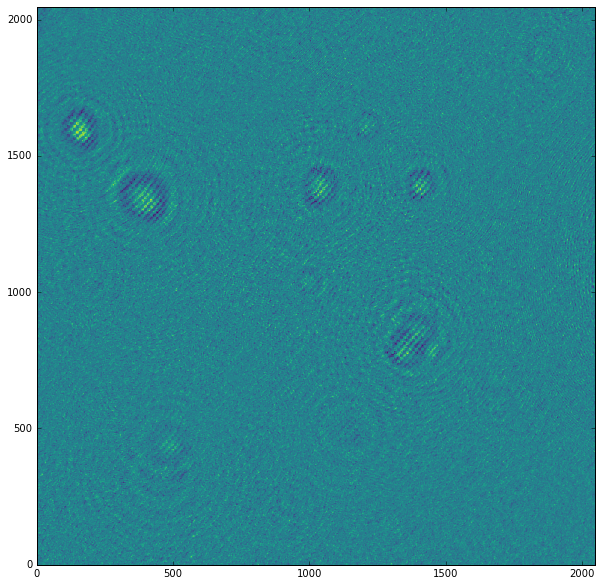

In [233]:
%matplotlib inline
def plot(array):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(array, **kwargs)
    plt.show()
h105 = holo_cube[104] - med
plot(h105)

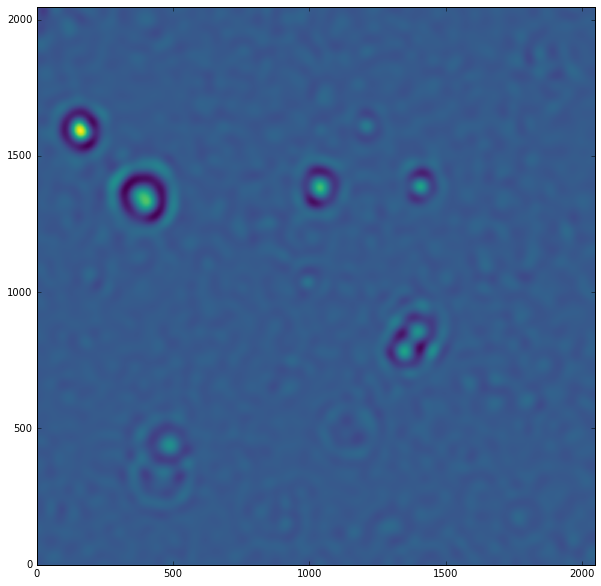

In [234]:
from pyfftw.interfaces.scipy_fftpack import fft2, ifft2
from astropy.convolution import convolve_fft, MexicanHat2DKernel, Gaussian2DKernel, Ring2DKernel
from scipy.ndimage import gaussian_filter

conv_small = convolve_fft(h105, MexicanHat2DKernel(25), fftn=fft2, ifftn=ifft2)

plot(conv_small)

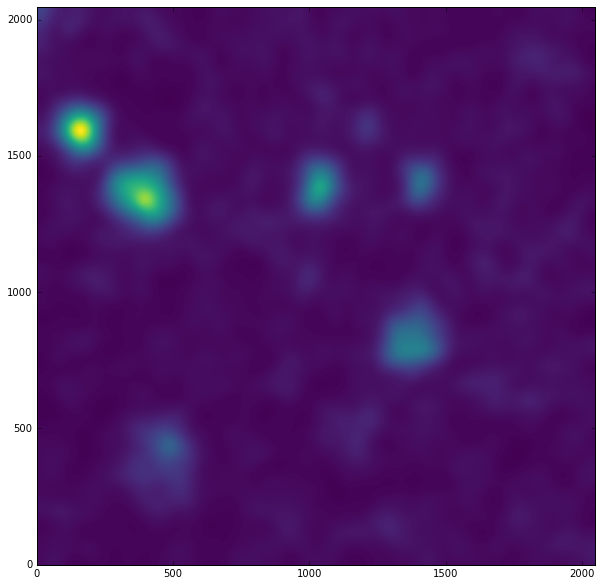

In [235]:
smooth_abs_conv = gaussian_filter(np.abs(conv_small), 30)
plot(smooth_abs_conv)

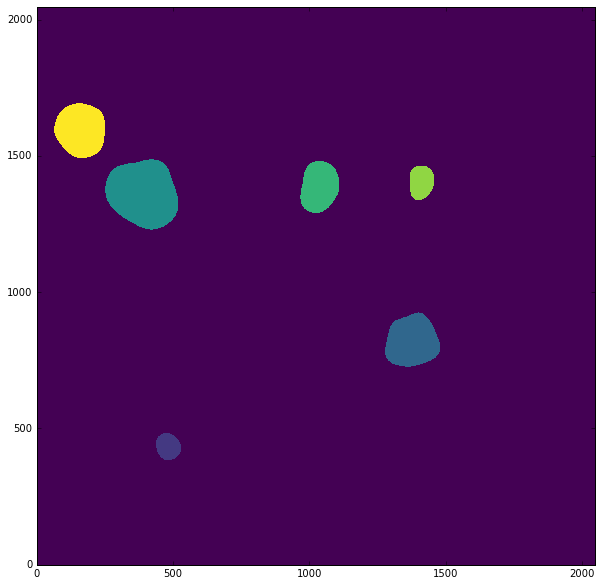

In [237]:
from skimage.filters import threshold_otsu, threshold_yen
from skimage.measure import label, regionprops

thresh = threshold_otsu(smooth_abs_conv)

masked = np.ones_like(conv_small)
masked[smooth_abs_conv <= thresh] = 0

label_image = label(masked)
plot(label_image)

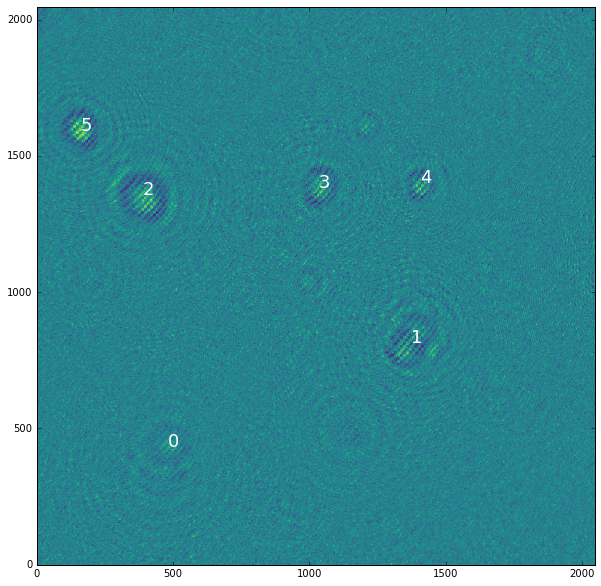

In [238]:
regions = regionprops(label_image, smooth_abs_conv)
centroids = [region.weighted_centroid for region in regions]

def plot_centroids(array, centroids):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array, **kwargs)
    for i, centroid in enumerate(centroids):
        ax.text(centroid[1], centroid[0], '{0}'.format(i), fontdict=dict(color='w', size=18))
    plt.show()

plot_centroids(h105, centroids)